<div>
<img img class="logo" src="https://medialib.cmcdn.dk/medialibrary/51432DDB-BBE3-4327-85F4-BE3493077470/1D874B35-F493-EC11-84B2-00155D0B0901.png" style="width: 100px;" align="right">
</div>

# <center> Assignment 2 - BuyWise Analytics

### <center> KAN-CDSCV1008U  Applied Machine Learning and Data Engineering in Business Context

## Data Preprocessing

`Initial Inspection`

In [46]:
# Importing modules 
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, accuracy_score

In [88]:
# Importing datasets 
path_frederik = "C:/Users/fredr/OneDrive/Documents/Master/Semester_3/Applied ML/AppliedML_Assign.01/Assignment2/Data/"
path_mathijs = "C:/Users/blk/OneDrive/Documenten/GitHub/ML-Final/AppliedML_Assign.01/Assignment2/Data"
path_guest = ""

os.chdir(path_mathijs)
path = os.getcwd()
print(path)

features = pd.read_csv("Features data set.csv")
sales = pd.read_csv("sales data-set.csv")
stores = pd.read_csv("stores data-set.csv")

C:\Users\blk\OneDrive\Documenten\GitHub\ML-Final\AppliedML_Assign.01\Assignment2\Data


In [48]:
# Convert the date column to datetime format 
features["Date"] = pd.to_datetime(features["Date"], format="%d/%m/%Y")
sales["Date"] = pd.to_datetime(sales["Date"], format="%d/%m/%Y")

`Data Cleaning`

In [49]:
# Forwoard fill impution for 'CPI' and 'Unemployment'
features['CPI'].fillna(method='ffill', inplace=True)
features['Unemployment'].fillna(method='ffill', inplace=True)

In [50]:
features['Week'] = features.Date.dt.isocalendar().week

In [51]:
# Imputing Markdown columns
# Impute NaN values based on weekly average
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_columns:
    weekly_avg = features.groupby('Week')[col].transform('mean')
    features[col].fillna(weekly_avg, inplace=True)

# can't impute all values for MarkDown2 , dropping Markdown2.

features.drop('MarkDown2', axis = 1, inplace=True)
features.drop('Week', axis=1, inplace=True)
features.head()


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,24089.612333,198.031818,24865.942619,4185.380333,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,29880.900556,197.092500,20305.431829,5089.147556,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,12536.748111,59.385610,7038.310625,5646.276000,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,8504.312444,25.995714,2879.735679,4458.685000,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,11293.039000,22.353662,6312.144304,2911.005778,211.350143,8.106,False


In [52]:
# Encoding 'IsHoliday' & 'Type'
label_encoder = LabelEncoder()
features['IsHoliday'] = label_encoder.fit_transform(features['IsHoliday'])
sales['IsHoliday'] = label_encoder.fit_transform(sales['IsHoliday'])
sales['Dept'] = label_encoder.fit_transform(sales['Dept'])
stores['Type'] = label_encoder.fit_transform(stores['Type'])

In [53]:
# Merging the data
tmp_df = pd.merge(sales, features, on=['Store', 'Date', 'IsHoliday'], how='left')
df = pd.merge(stores, tmp_df, on=['Store'], how='left')
df.head()

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,0,151315,0,2010-02-05,24924.50,0,42.31,2.572,24089.612333,198.031818,24865.942619,4185.380333,211.096358,8.106
1,1,0,151315,0,2010-02-12,46039.49,1,38.51,2.548,29880.900556,197.092500,20305.431829,5089.147556,211.242170,8.106
2,1,0,151315,0,2010-02-19,41595.55,0,39.93,2.514,12536.748111,59.385610,7038.310625,5646.276000,211.289143,8.106
3,1,0,151315,0,2010-02-26,19403.54,0,46.63,2.561,8504.312444,25.995714,2879.735679,4458.685000,211.319643,8.106
4,1,0,151315,0,2010-03-05,21827.90,0,46.50,2.625,11293.039000,22.353662,6312.144304,2911.005778,211.350143,8.106


In [54]:
# Scaling the data 
def normalize_col(data):
    scaled_data = data.copy()
    scaler = StandardScaler()
    for col in data.columns.values.tolist():
        if col != 'Date':
            scaled_data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return scaled_data

df_scaled = normalize_col(df)
df_scaled.head()

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,-1.658199,-0.885307,0.239209,-1.560345,2010-02-05,0.393782,-0.275106,-0.963798,-1.720834,2.510646,-0.110208,4.135339,-0.003344,1.018774,0.078201
1,-1.658199,-0.885307,0.239209,-1.560345,2010-02-12,1.323501,3.634961,-1.169783,-1.773177,3.380049,-0.110327,3.256627,0.230207,1.022498,0.078201
2,-1.658199,-0.885307,0.239209,-1.560345,2010-02-19,1.127829,-0.275106,-1.092810,-1.847330,0.776302,-0.127816,0.700341,0.374179,1.023697,0.078201
3,-1.658199,-0.885307,0.239209,-1.560345,2010-02-26,0.150687,-0.275106,-0.729625,-1.744825,0.170943,-0.132057,-0.100926,0.067283,1.024476,0.078201
4,-1.658199,-0.885307,0.239209,-1.560345,2010-03-05,0.257435,-0.275106,-0.736672,-1.605243,0.589593,-0.132519,0.560425,-0.332666,1.025255,0.078201


In [55]:
print(df.head())

   Store  Type    Size  Dept       Date  Weekly_Sales  IsHoliday  Temperature   
0      1     0  151315     0 2010-02-05      24924.50          0        42.31  \
1      1     0  151315     0 2010-02-12      46039.49          1        38.51   
2      1     0  151315     0 2010-02-19      41595.55          0        39.93   
3      1     0  151315     0 2010-02-26      19403.54          0        46.63   
4      1     0  151315     0 2010-03-05      21827.90          0        46.50   

   Fuel_Price     MarkDown1   MarkDown3     MarkDown4    MarkDown5   
0       2.572  24089.612333  198.031818  24865.942619  4185.380333  \
1       2.548  29880.900556  197.092500  20305.431829  5089.147556   
2       2.514  12536.748111   59.385610   7038.310625  5646.276000   
3       2.561   8504.312444   25.995714   2879.735679  4458.685000   
4       2.625  11293.039000   22.353662   6312.144304  2911.005778   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2 

`Exploratory Data Analysis`

In [56]:
df_date = df.groupby('Date').agg({'Temperature': 'mean',
                                       'Fuel_Price': 'mean',
                                       'CPI': 'mean',
                                       'Unemployment': 'mean', 
                                       'Weekly_Sales': 'mean',
                                       'IsHoliday': 'min',
                                       'MarkDown1': 'mean',
                                       'MarkDown3': 'mean',
                                       'MarkDown4': 'mean',
                                       'MarkDown5': 'mean'}).reset_index()
df_date.head()

,Date,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,IsHoliday,MarkDown1,MarkDown3,MarkDown4,MarkDown5
0,2010-02-05,33.277942,2.717869,167.398405,8.576731,16836.121997,0,24089.612333,198.031818,24865.942619,4185.380333
1,2010-02-12,33.361810,2.696102,167.384138,8.567309,16352.056032,1,29880.900556,197.092500,20305.431829,5089.147556
2,2010-02-19,37.038310,2.673666,167.338966,8.576351,16216.658979,0,12536.748111,59.385610,7038.310625,5646.276000
3,2010-02-26,38.629563,2.685642,167.691019,8.561375,14899.549688,0,8504.312444,25.995714,2879.735679,4458.685000
4,2010-03-05,42.373998,2.731816,167.727351,8.572689,15921.015727,0,11293.039000,22.353662,6312.144304,2911.005778


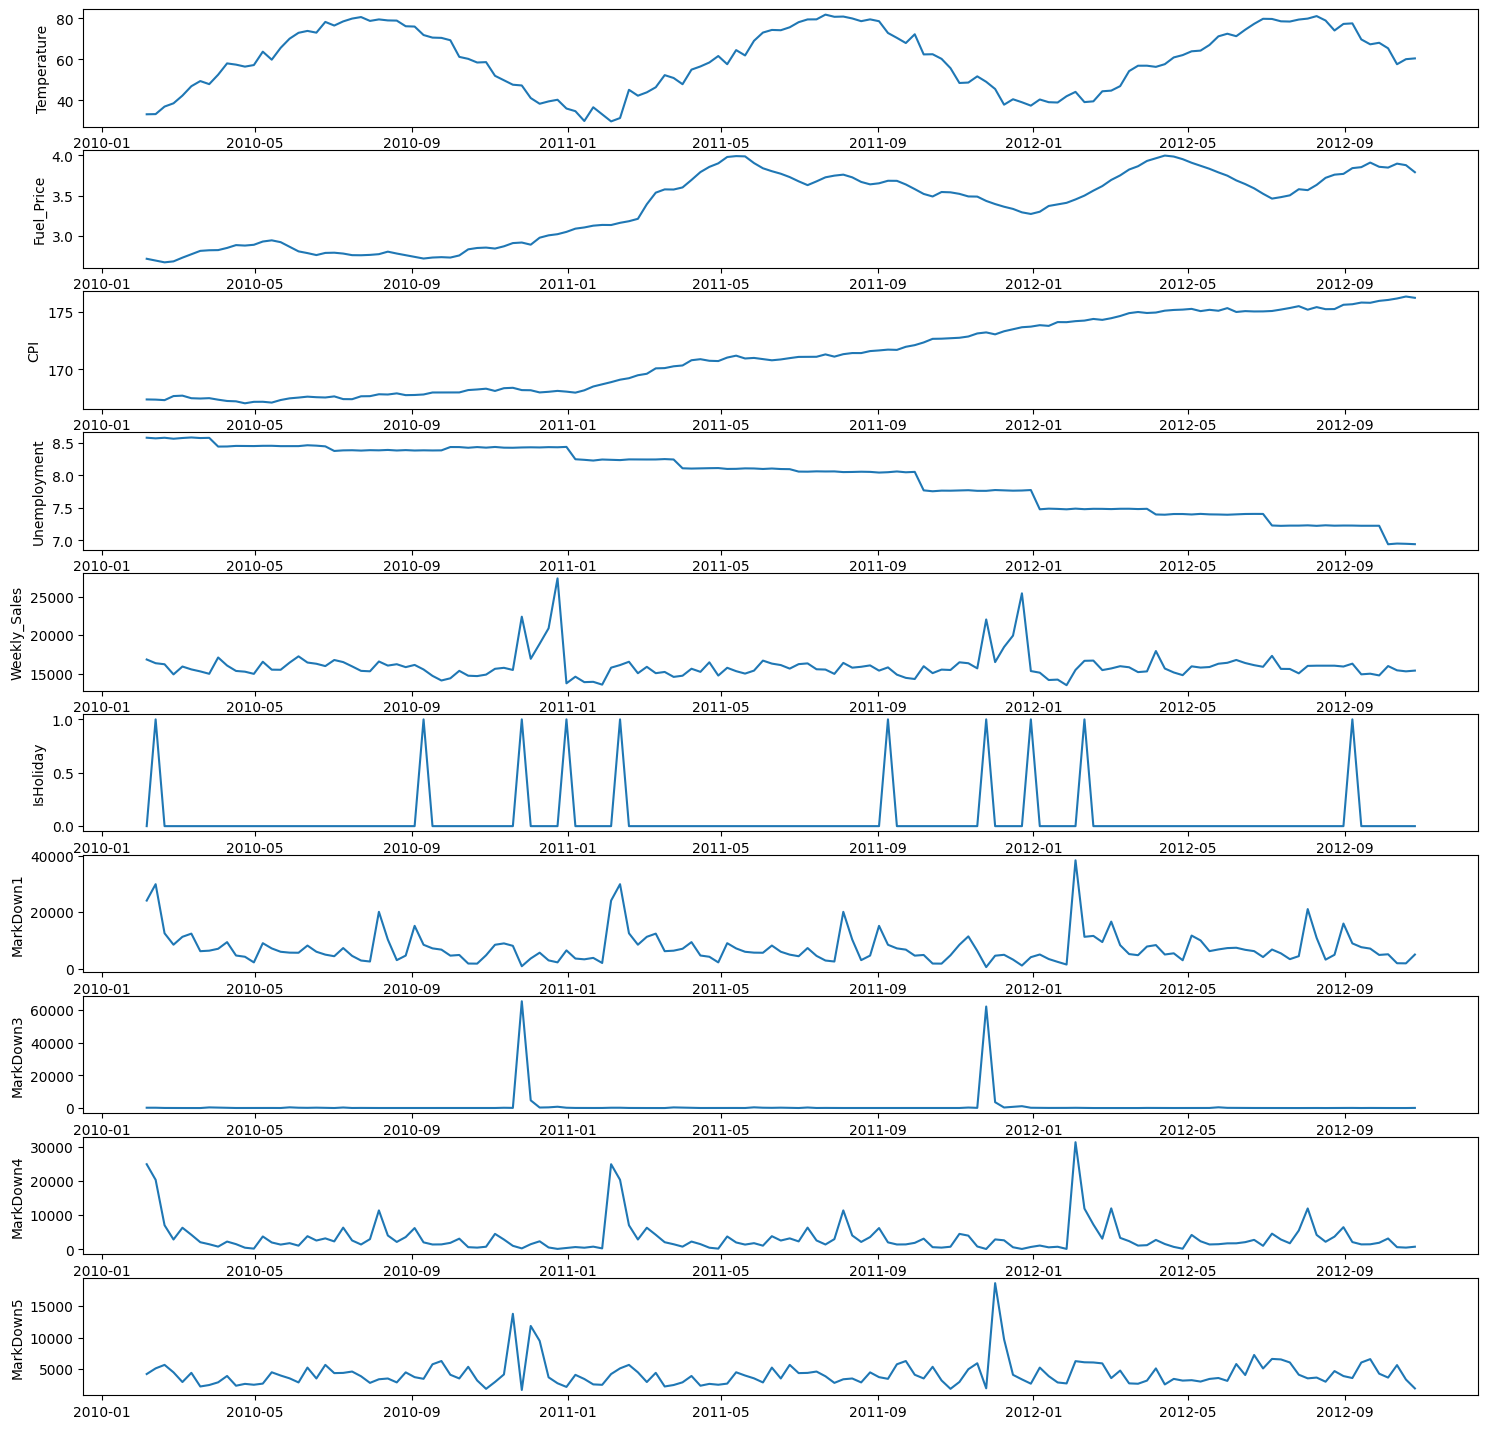

In [58]:
# Plotting all features
fig = plt.figure(figsize = (18, 18))
count_columns_ex_date = len(df_date.columns[1:])
for idx, col in enumerate(df_date.columns[1:]):
    plt.subplot(count_columns_ex_date, 1, idx+1)
    plt.plot(df_date["Date"], df_date[col])
    plt.ylabel(col)

## Success Factor Analysis

In [59]:
aggregated_df = df.groupby(['Store', 'Date']).agg({
    'Type': 'mean',
    'Size': 'mean',
    'Dept': 'mean',
    'Weekly_Sales': 'sum',  # Sum the weekly sales for each store and week
    'IsHoliday': 'mean',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'MarkDown1': 'mean',
    'MarkDown3': 'mean',
    'MarkDown4': 'mean',
    'MarkDown5': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
}).reset_index()

In [60]:
aggregated_df.drop("Dept", axis=1, inplace= True)
aggregated_df["Relative Sales"] = aggregated_df["Weekly_Sales"] / aggregated_df["Size"]
aggregated_df.head()

,Store,Date,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Relative Sales
0,1,2010-02-05,0.0,151315.0,1643690.90,0.0,42.31,2.572,24089.612333,198.031818,24865.942619,4185.380333,211.096358,8.106,10.862710
1,1,2010-02-12,0.0,151315.0,1641957.44,1.0,38.51,2.548,29880.900556,197.092500,20305.431829,5089.147556,211.242170,8.106,10.851254
2,1,2010-02-19,0.0,151315.0,1611968.17,0.0,39.93,2.514,12536.748111,59.385610,7038.310625,5646.276000,211.289143,8.106,10.653063
3,1,2010-02-26,0.0,151315.0,1409727.59,0.0,46.63,2.561,8504.312444,25.995714,2879.735679,4458.685000,211.319643,8.106,9.316509
4,1,2010-03-05,0.0,151315.0,1554806.68,0.0,46.50,2.625,11293.039000,22.353662,6312.144304,2911.005778,211.350143,8.106,10.275298


In [61]:
#find top 5 stores of last 3 months 
filtered_df = aggregated_df[(aggregated_df["Date"]>= "2012-08-03") &(aggregated_df["Date"]<="2012-10-26")]

#group by store and sum up relative sales
store_sales_sum = filtered_df.groupby('Store')['Relative Sales'].sum().reset_index()

# Sort the stores by the sum of "Relative Sales" in descending order and get the top 5 stores
top_5_stores = store_sales_sum.nlargest(5, 'Relative Sales')

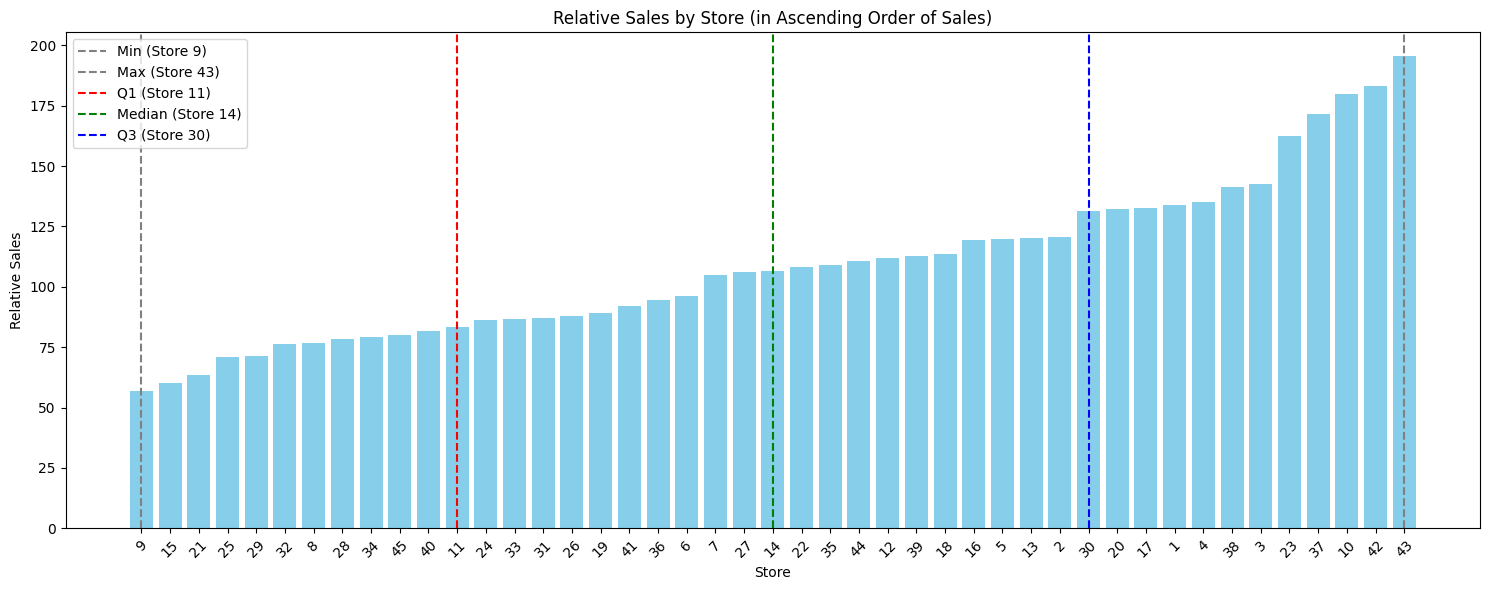

In [62]:
# Sort the dataframe by 'Relative Sales' for the purpose of plotting
sorted_df = store_sales_sum.sort_values(by="Relative Sales", ascending=True)

# Calculate statistics
min_value = sorted_df['Relative Sales'].min()
max_value = sorted_df['Relative Sales'].max()
first_quartile = sorted_df['Relative Sales'].quantile(0.25)
median_value = sorted_df['Relative Sales'].quantile(0.5)
third_quartile = sorted_df['Relative Sales'].quantile(0.75)

# Find the stores corresponding to these statistics
min_store = sorted_df[sorted_df['Relative Sales'] == min_value]['Store'].values[0]
max_store = sorted_df[sorted_df['Relative Sales'] == max_value]['Store'].values[0]
first_quartile_store = sorted_df[sorted_df['Relative Sales'] == first_quartile]['Store'].values[0]
median_store = sorted_df[sorted_df['Relative Sales'] == median_value]['Store'].values[0]
third_quartile_store = sorted_df[sorted_df['Relative Sales'] == third_quartile]['Store'].values[0]

# Create bar chart
plt.figure(figsize=(15, 6))
bars = plt.bar(sorted_df['Store'].astype(str), sorted_df['Relative Sales'], color='skyblue')  # Convert store numbers to strings

# Adding labels and title
plt.xlabel('Store')
plt.ylabel('Relative Sales')
plt.title('Relative Sales by Store (in Ascending Order of Sales)')

# Draw vertical lines for the quartiles, min, and max
plt.axvline(x=0, color='grey', linestyle='--', label=f'Min (Store {min_store})')
plt.axvline(x=44, color='grey', linestyle='--', label=f'Max (Store {max_store})')
plt.axvline(x=11, color='r', linestyle='--', label=f'Q1 (Store {first_quartile_store})')
plt.axvline(x=22, color='g', linestyle='--', label=f'Median (Store {median_store})')
plt.axvline(x=33, color='b', linestyle='--', label=f'Q3 (Store {third_quartile_store})')

plt.legend()
plt.xticks(rotation=45)  # Rotate store labels for better readability
plt.tight_layout()

# Show plot
plt.show()

In [63]:
top_5_stores
#the 43, 42,10,37,23

,Store,Relative Sales
42,43,195.602390
41,42,183.043413
9,10,179.668021
36,37,171.359844
22,23,162.355635


In [64]:
store_sales_sum.sort_values(by="Relative Sales", ascending=False, inplace=True)

,Store,Relative Sales
42,43,195.602390
41,42,183.043413
9,10,179.668021
36,37,171.359844
22,23,162.355635
2,3,142.606465
37,38,141.380340
3,4,135.223843
0,1,133.929805
16,17,132.775059


In [65]:
top5 = [43, 42, 10, 37, 23]
top5_df = filtered_df[filtered_df["Store"].isin(top5)]#.groupby('Store')???
top5_df

,Store,Date,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Relative Sales
1417,10,2012-08-03,1.0,126512.0,1939440.09,0.0,84.76,3.595,37194.44,53.400000,21623.930000,2549.27,130.737871,7.170,15.330088
1418,10,2012-08-10,1.0,126512.0,1880436.94,0.0,90.78,3.811,15282.47,58.800000,5537.010000,14827.71,130.756161,7.170,14.863704
1419,10,2012-08-17,1.0,126512.0,1827797.40,0.0,88.83,4.002,4407.90,7.200000,3037.560000,3717.52,130.790968,7.170,14.447621
1420,10,2012-08-24,1.0,126512.0,1764984.15,0.0,82.50,4.055,11322.69,34.000000,6602.590000,7256.22,130.838161,7.170,13.951120
1421,10,2012-08-31,1.0,126512.0,1650285.54,0.0,86.97,3.886,26218.85,68.240000,12440.510000,3544.68,130.885355,7.170,13.044498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6144,43,2012-09-28,2.0,41062.0,577792.32,0.0,77.55,3.666,343.99,6.735758,1899.329737,1087.72,214.305250,9.285,14.071217
6145,43,2012-10-05,2.0,41062.0,642614.89,0.0,74.09,3.617,183.84,0.010000,3124.299474,3093.39,214.491267,8.839,15.649868
6146,43,2012-10-12,2.0,41062.0,619369.72,0.0,71.14,3.601,90.11,14.560000,639.365405,911.55,214.677283,8.839,15.083769
6147,43,2012-10-19,2.0,41062.0,623919.23,0.0,71.25,3.594,121.84,11.140000,507.965000,964.01,214.721249,8.839,15.194565


In [66]:
top5_df = top5_df.sort_values(by = ["Store", "Date"], ascending=[True, True])
top5_df

,Store,Date,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Relative Sales
1417,10,2012-08-03,1.0,126512.0,1939440.09,0.0,84.76,3.595,37194.44,53.400000,21623.930000,2549.27,130.737871,7.170,15.330088
1418,10,2012-08-10,1.0,126512.0,1880436.94,0.0,90.78,3.811,15282.47,58.800000,5537.010000,14827.71,130.756161,7.170,14.863704
1419,10,2012-08-17,1.0,126512.0,1827797.40,0.0,88.83,4.002,4407.90,7.200000,3037.560000,3717.52,130.790968,7.170,14.447621
1420,10,2012-08-24,1.0,126512.0,1764984.15,0.0,82.50,4.055,11322.69,34.000000,6602.590000,7256.22,130.838161,7.170,13.951120
1421,10,2012-08-31,1.0,126512.0,1650285.54,0.0,86.97,3.886,26218.85,68.240000,12440.510000,3544.68,130.885355,7.170,13.044498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6144,43,2012-09-28,2.0,41062.0,577792.32,0.0,77.55,3.666,343.99,6.735758,1899.329737,1087.72,214.305250,9.285,14.071217
6145,43,2012-10-05,2.0,41062.0,642614.89,0.0,74.09,3.617,183.84,0.010000,3124.299474,3093.39,214.491267,8.839,15.649868
6146,43,2012-10-12,2.0,41062.0,619369.72,0.0,71.14,3.601,90.11,14.560000,639.365405,911.55,214.677283,8.839,15.083769
6147,43,2012-10-19,2.0,41062.0,623919.23,0.0,71.25,3.594,121.84,11.140000,507.965000,964.01,214.721249,8.839,15.194565


In [67]:
droptop = ["MarkDown1", "MarkDown3","MarkDown4","MarkDown5"]
top5_df.drop(droptop, axis=1, inplace=True)

In [68]:
top5_df.head()

,Store,Date,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Relative Sales
1417,10,2012-08-03,1.0,126512.0,1939440.09,0.0,84.76,3.595,130.737871,7.17,15.330088
1418,10,2012-08-10,1.0,126512.0,1880436.94,0.0,90.78,3.811,130.756161,7.17,14.863704
1419,10,2012-08-17,1.0,126512.0,1827797.40,0.0,88.83,4.002,130.790968,7.17,14.447621
1420,10,2012-08-24,1.0,126512.0,1764984.15,0.0,82.50,4.055,130.838161,7.17,13.951120
1421,10,2012-08-31,1.0,126512.0,1650285.54,0.0,86.97,3.886,130.885355,7.17,13.044498


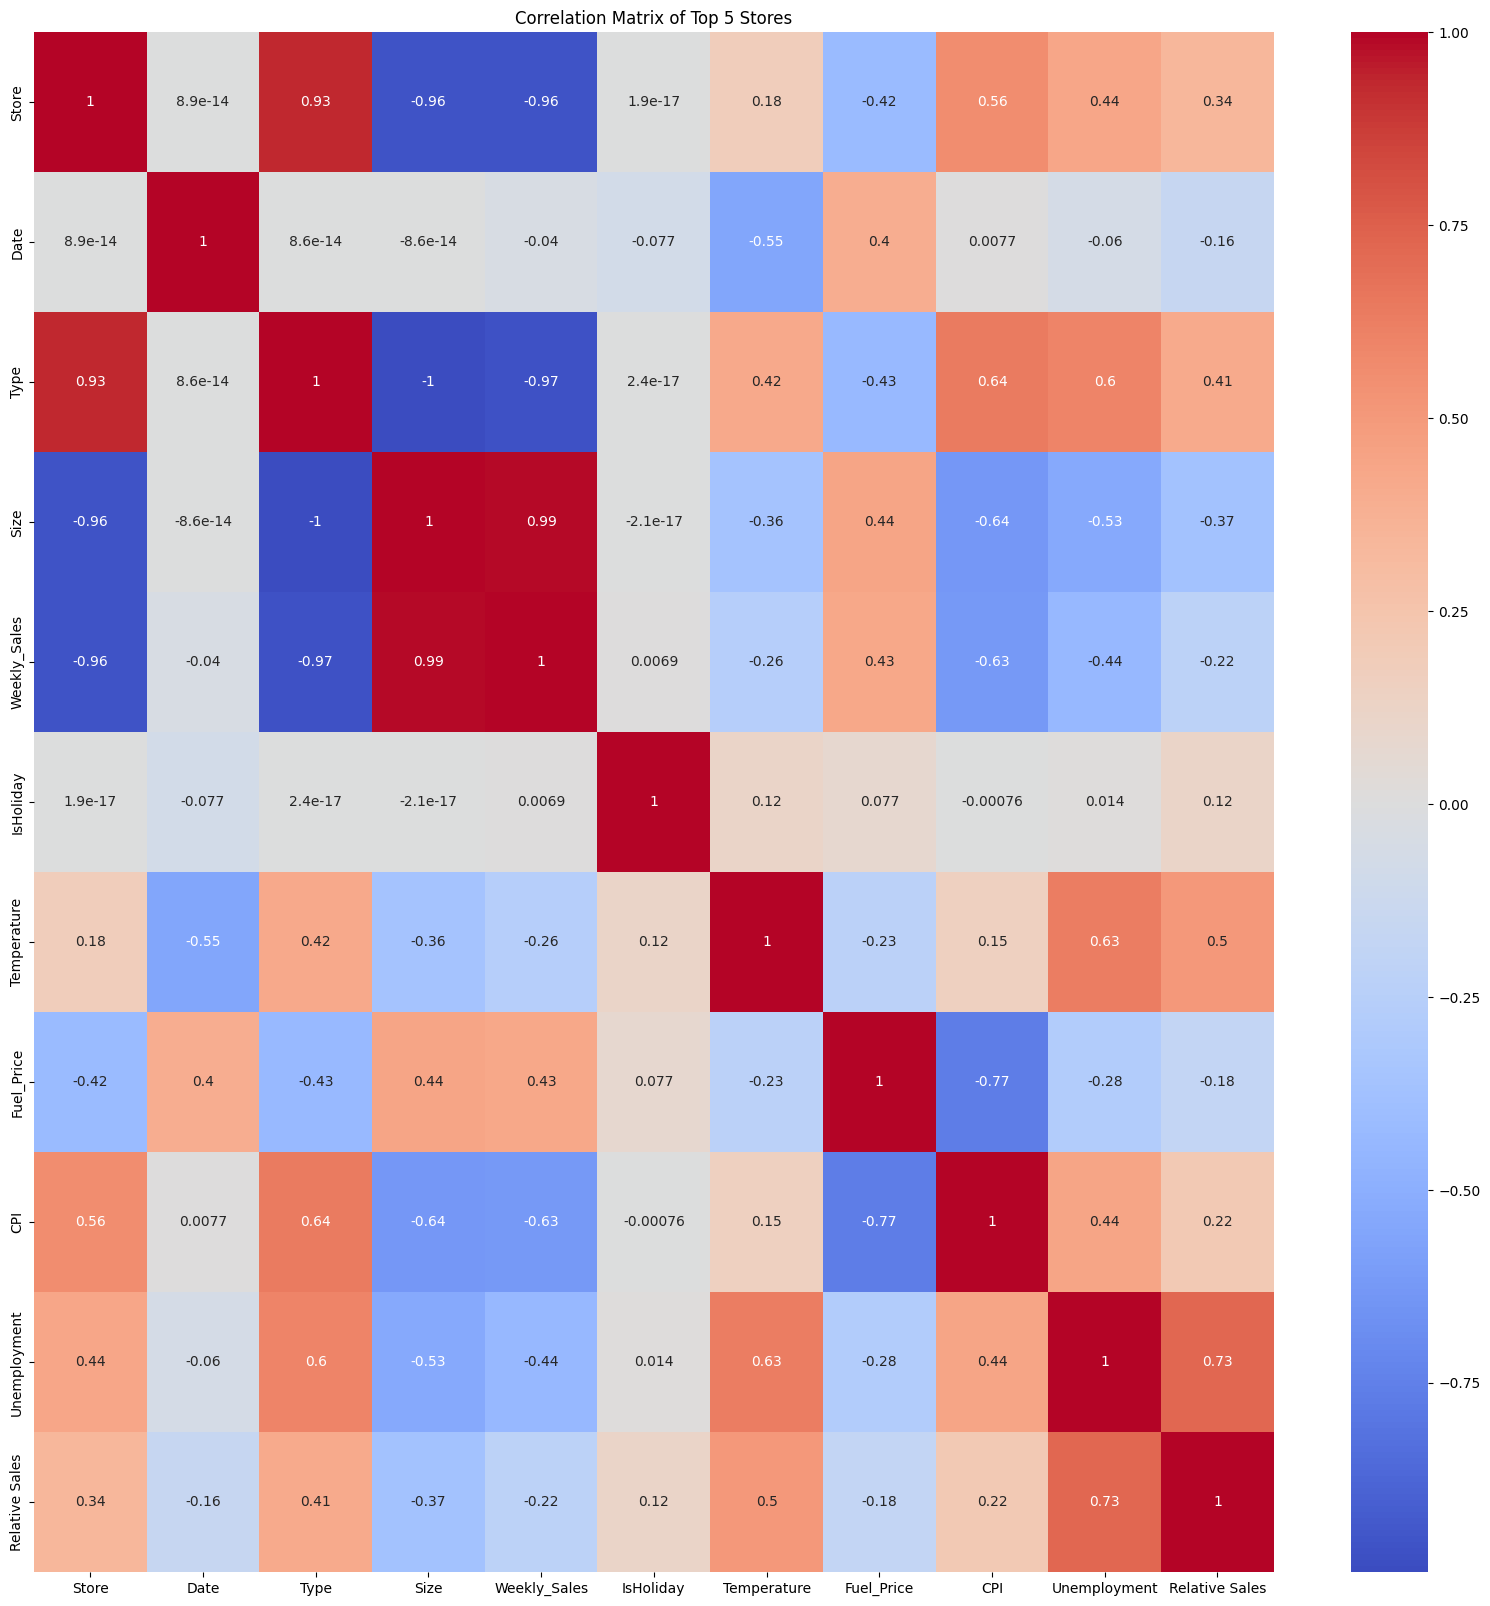

In [69]:
#correlation matrix for Top5
corr_matrix = top5_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') 
plt.title("Correlation Matrix of Top 5 Stores")
plt.show()

In [70]:
low_5_stores = store_sales_sum.nsmallest(5, 'Relative Sales')
low_5_stores

,Store,Relative Sales
8,9,56.851860
14,15,59.954463
20,21,63.630150
24,25,70.785696
28,29,71.360752


In [71]:
low5 = [9, 15, 21, 25, 29]
low5_df = filtered_df[filtered_df["Store"].isin(low5)]
low5_df

,Store,Date,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Relative Sales
1274,9,2012-08-03,1.0,125833.0,533887.54,0.0,90.23,3.417,11864.50,0.220000,1659.09,2176.37,225.707044,5.277,4.242826
1275,9,2012-08-10,1.0,125833.0,538713.47,0.0,88.66,3.494,3180.78,1.400000,2112.03,2314.58,225.717009,5.277,4.281178
1276,9,2012-08-17,1.0,125833.0,535153.47,0.0,86.37,3.571,975.91,3.000000,325.68,670.48,225.799532,5.277,4.252887
1277,9,2012-08-24,1.0,125833.0,572887.78,0.0,77.90,3.620,1524.71,1.800000,501.16,4241.59,225.936473,5.277,4.552763
1278,9,2012-08-31,1.0,125833.0,576879.15,0.0,80.71,3.638,5758.14,17.600000,2828.89,1884.13,226.073413,5.277,4.584482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,29,2012-09-28,1.0,93638.0,489674.23,0.0,62.17,4.018,4039.87,1.980000,687.56,3822.63,138.739500,9.419,5.229439
4143,29,2012-10-05,1.0,93638.0,520632.80,0.0,62.09,4.027,4727.88,9.120000,676.30,1904.05,138.825600,9.151,5.560059
4144,29,2012-10-12,1.0,93638.0,513737.00,0.0,54.18,4.029,2264.29,6.800000,829.39,675.12,138.911700,9.151,5.486416
4145,29,2012-10-19,1.0,93638.0,516909.24,0.0,55.28,4.000,1021.83,2.280000,194.24,3821.21,138.833613,9.151,5.520293


In [72]:
low5_df = low5_df.sort_values(by = ["Store", "Date"], ascending=[True, True])
low5_df["Type"].unique()

array([1.])

In [73]:
drop = ["MarkDown1", "MarkDown3","MarkDown4","MarkDown5", "Type", "Weekly_Sales"]
low5_df.drop(drop, axis=1, inplace=True)

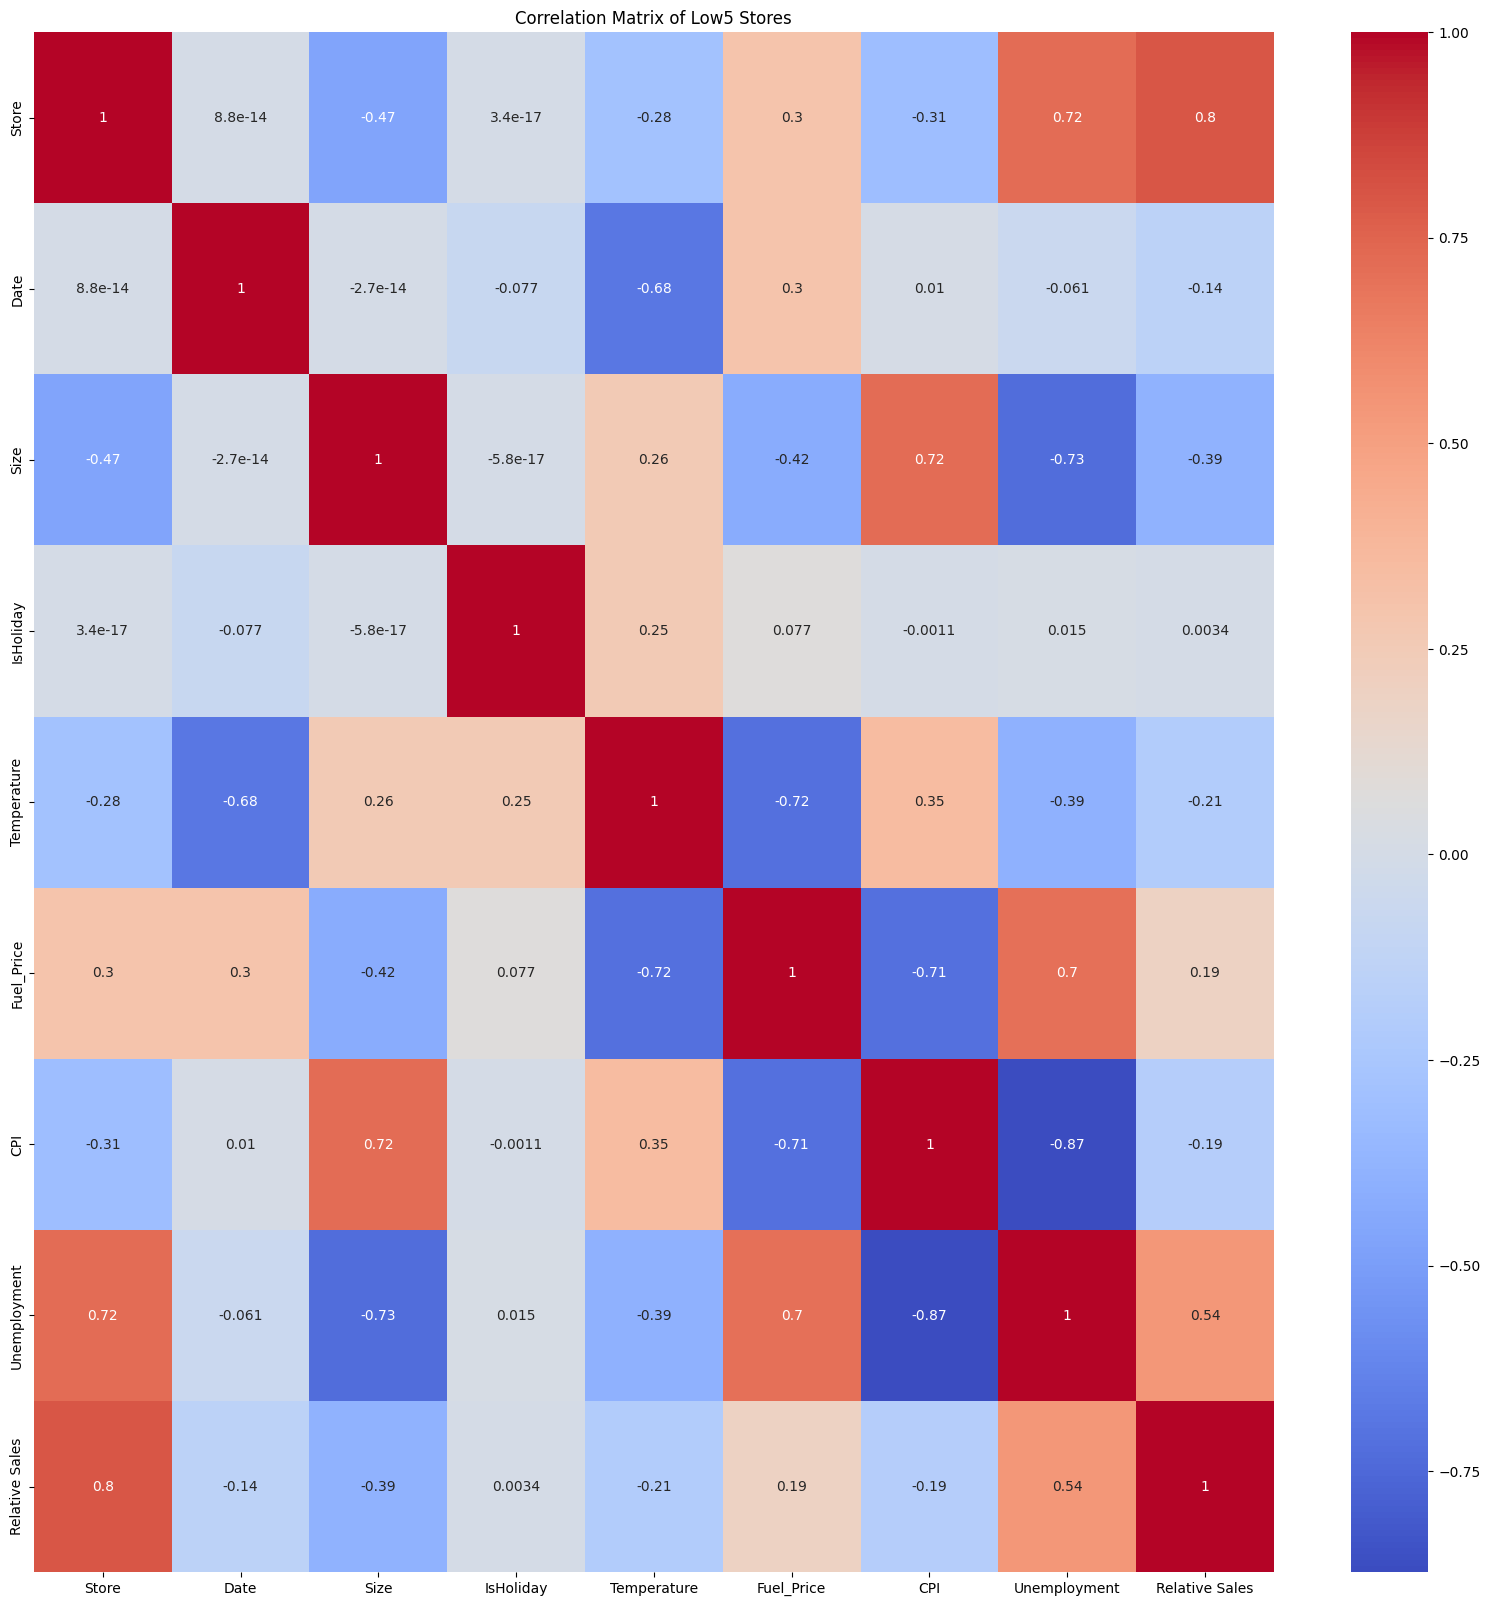

In [74]:
#correlation matrix for low5

corr_matrix = low5_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm') 
plt.title("Correlation Matrix of Low5 Stores")
plt.show()

In [75]:
dfr = [top5_df, low5_df]
df = pd.concat(dfr)
df

,Store,Date,Type,Size,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Relative Sales
1417,10,2012-08-03,1.0,126512.0,1939440.09,0.0,84.76,3.595,130.737871,7.170,15.330088
1418,10,2012-08-10,1.0,126512.0,1880436.94,0.0,90.78,3.811,130.756161,7.170,14.863704
1419,10,2012-08-17,1.0,126512.0,1827797.40,0.0,88.83,4.002,130.790968,7.170,14.447621
1420,10,2012-08-24,1.0,126512.0,1764984.15,0.0,82.50,4.055,130.838161,7.170,13.951120
1421,10,2012-08-31,1.0,126512.0,1650285.54,0.0,86.97,3.886,130.885355,7.170,13.044498
...,...,...,...,...,...,...,...,...,...,...,...
4142,29,2012-09-28,NaN,93638.0,NaN,0.0,62.17,4.018,138.739500,9.419,5.229439
4143,29,2012-10-05,NaN,93638.0,NaN,0.0,62.09,4.027,138.825600,9.151,5.560059
4144,29,2012-10-12,NaN,93638.0,NaN,0.0,54.18,4.029,138.911700,9.151,5.486416
4145,29,2012-10-19,NaN,93638.0,NaN,0.0,55.28,4.000,138.833613,9.151,5.520293


In [76]:
df.dropna(axis=1, inplace = True)

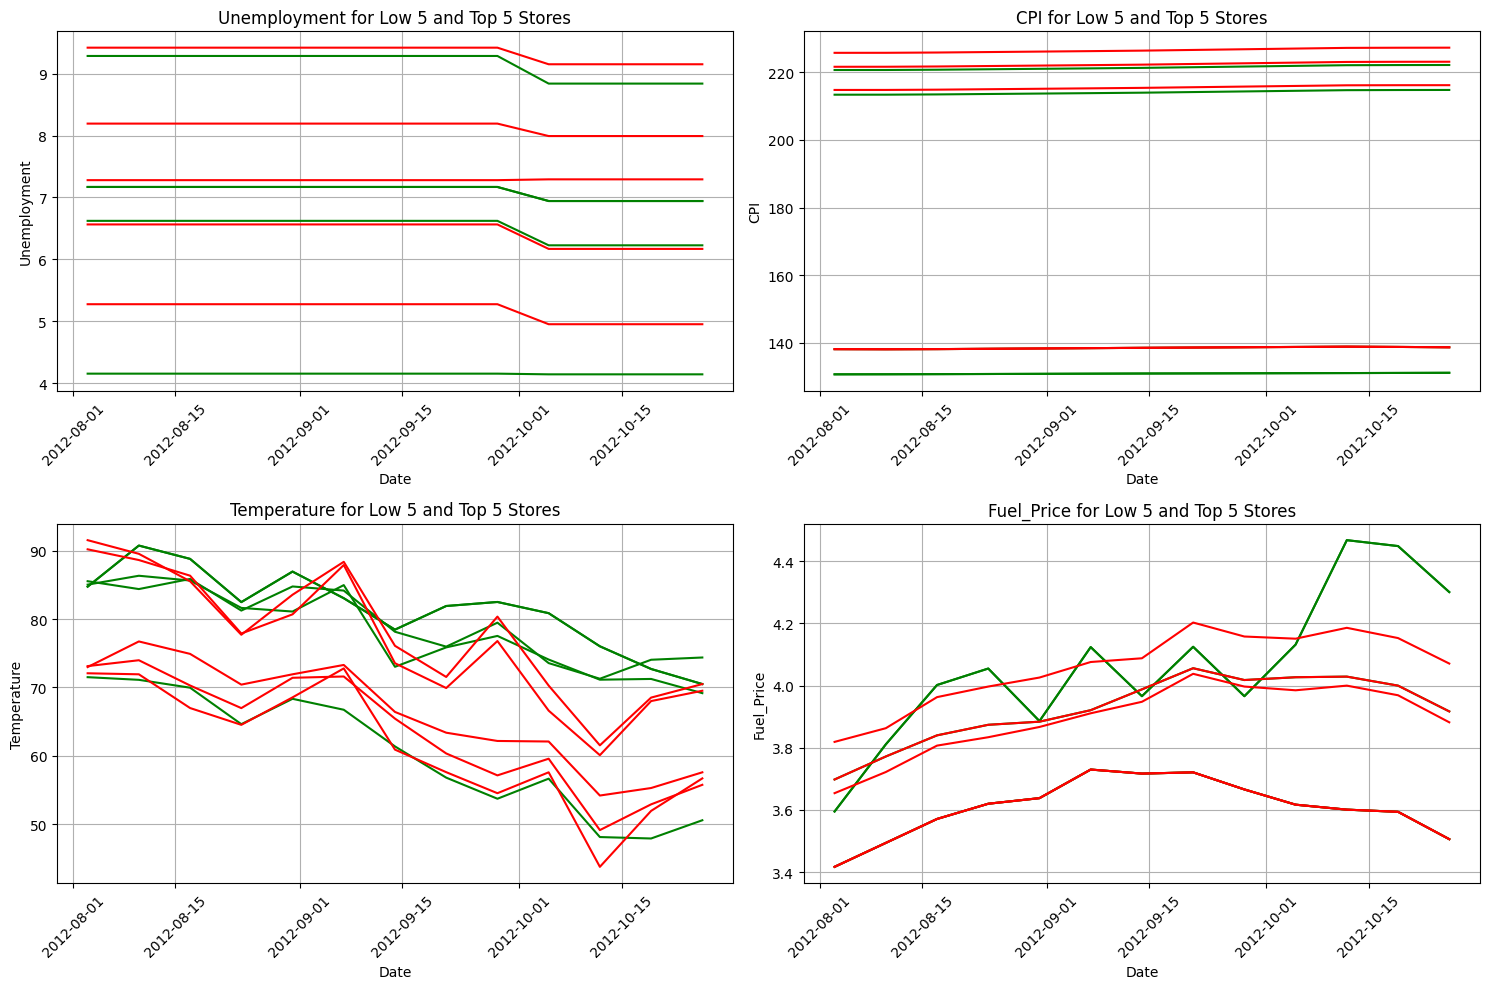

In [77]:
#line chart for selected features
#features = df.columns
features = ["Unemployment", "CPI", "Temperature", "Fuel_Price"]

# Define the stores that will be plotted
stores = df['Store'].unique()

plt.figure(figsize=(15, 10))

# Define colors for low5 and top5 stores
colors = {}
low5 = [9, 15, 21, 25, 29]
top5 = [43, 42, 10, 37, 23]

for store in stores:
    if store in low5:
        colors[store] = 'red'
    elif store in top5:
        colors[store] = 'green'
    
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    plt.title(f'{feature} for Low 5 and Top 5 Stores')
    plt.xlabel('Date')
    plt.ylabel(feature)

    for store in stores:
        store_data = df[df['Store'] == store]
        plt.plot(store_data['Date'], store_data[feature], label=f'Store {store}', color=colors[store])

    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Prediction Models

`Feature Engineering and Data Preperation`

In [78]:
# Creating time features 
df_scaled['DayOfMonth'] = df_scaled['Date'].dt.day
df_scaled['DayOfWeek'] = df_scaled['Date'].dt.dayofweek
df_scaled['Quarter'] = df_scaled['Date'].dt.quarter
df_scaled['Month'] = df_scaled['Date'].dt.month
df_scaled['Year'] = df_scaled['Date'].dt.year
df_scaled['DayOfYear'] = df_scaled['Date'].dt.dayofyear
df_scaled['WeekOfYear'] = df_scaled['Date'].dt.isocalendar().week

In [79]:
# Splitting the data into train- and test set
split_indx = int(0.8*len(df_scaled))

train = df_scaled[:split_indx]
test = df_scaled[split_indx:]

In [80]:
# Setting date as index 
train = train.set_index('Date')
test = test.set_index('Date')

In [81]:
train.shape
train.columns

Index(['Store', 'Type', 'Size', 'Dept', 'Weekly_Sales', 'IsHoliday',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'DayOfMonth', 'DayOfWeek',
       'Quarter', 'Month', 'Year', 'DayOfYear', 'WeekOfYear'],
      dtype='object')

In [82]:
# Defining target variable and features 
X_train = train.drop('Weekly_Sales', axis=1)
y_train = train['Weekly_Sales']

X_test = test.drop('Weekly_Sales', axis=1)
y_test = test['Weekly_Sales']

`Linear Regression`

In [83]:
# Initialize Linear Regression 
osl = LinearRegression()
osl.fit(X_train, y_train)

LinearRegression()

In [84]:
# Evaluating the model 

# Getting the predicted values from the regressor 
test['OSL_Predictions'] = osl.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(test['Weekly_Sales'], test['OSL_Predictions'])
mae = mean_absolute_error(test['Weekly_Sales'], test['OSL_Predictions'])
r2 = r2_score(test['Weekly_Sales'], test['OSL_Predictions'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 0.7133
Mean Absolute Error: 0.5144
R-squared: -0.0158


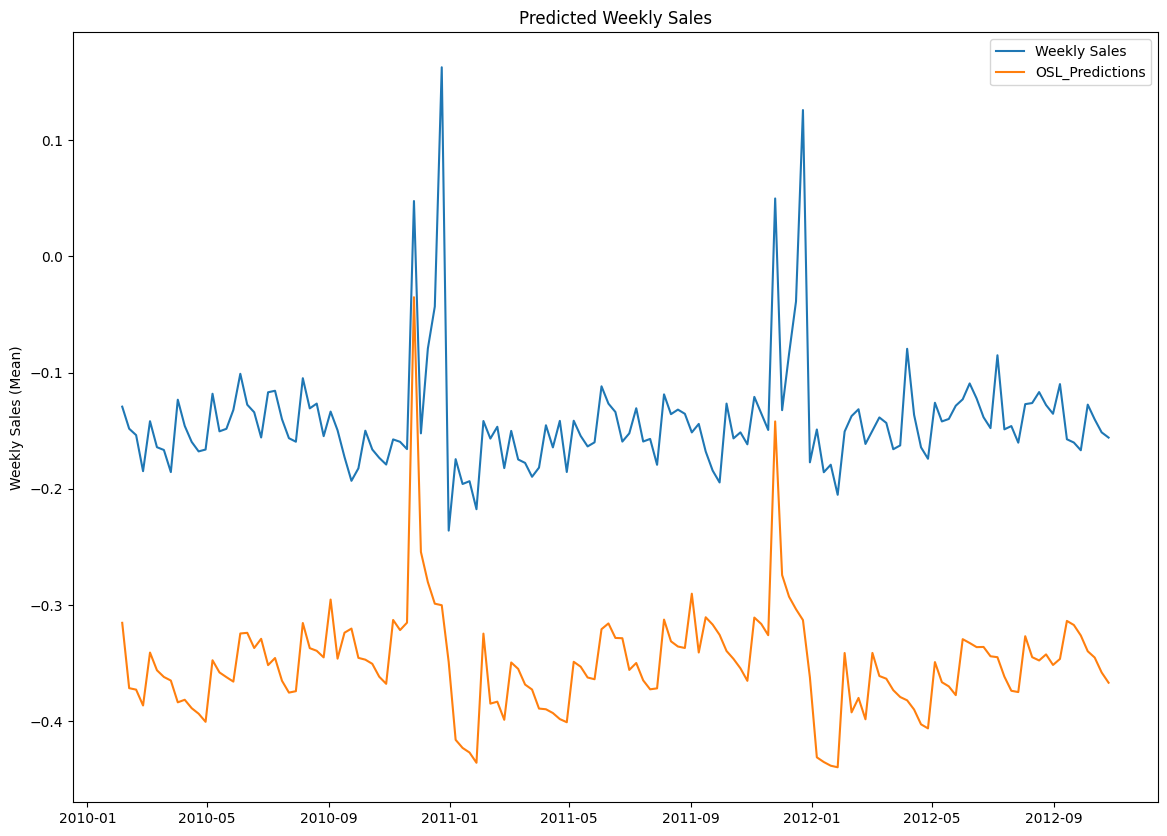

In [85]:
# Plotting the visualizations 

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'OSL_Predictions': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['OSL_Predictions'], label='OSL_Predictions')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()

`Random Forest Regressor`

In [86]:
# Initializing Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [90]:
import joblib
filename = os.path.join(path, 'randomforestregressor.pkl')

if os.path.exists(filename):
    print("Error: The file already exists! Please choose a different name or location.")
else:
    joblib.dump(rf, filename)


Error: The file already exists! Please choose a different name or location.


In [91]:
rf_path = os.path.join(path, 'randomforestregressor.pkl')
saved_rf = joblib.load(rf_path)

In [92]:
# Evaluating the model 

# Getting the predicted values from the regressor 
test['RF_Predictions'] = saved_rf.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(test['Weekly_Sales'], test['RF_Predictions'])
mae = mean_absolute_error(test['Weekly_Sales'], test['RF_Predictions'])
r2 = r2_score(test['Weekly_Sales'], test['RF_Predictions'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 0.1669
Mean Absolute Error: 0.1965
R-squared: 0.7623


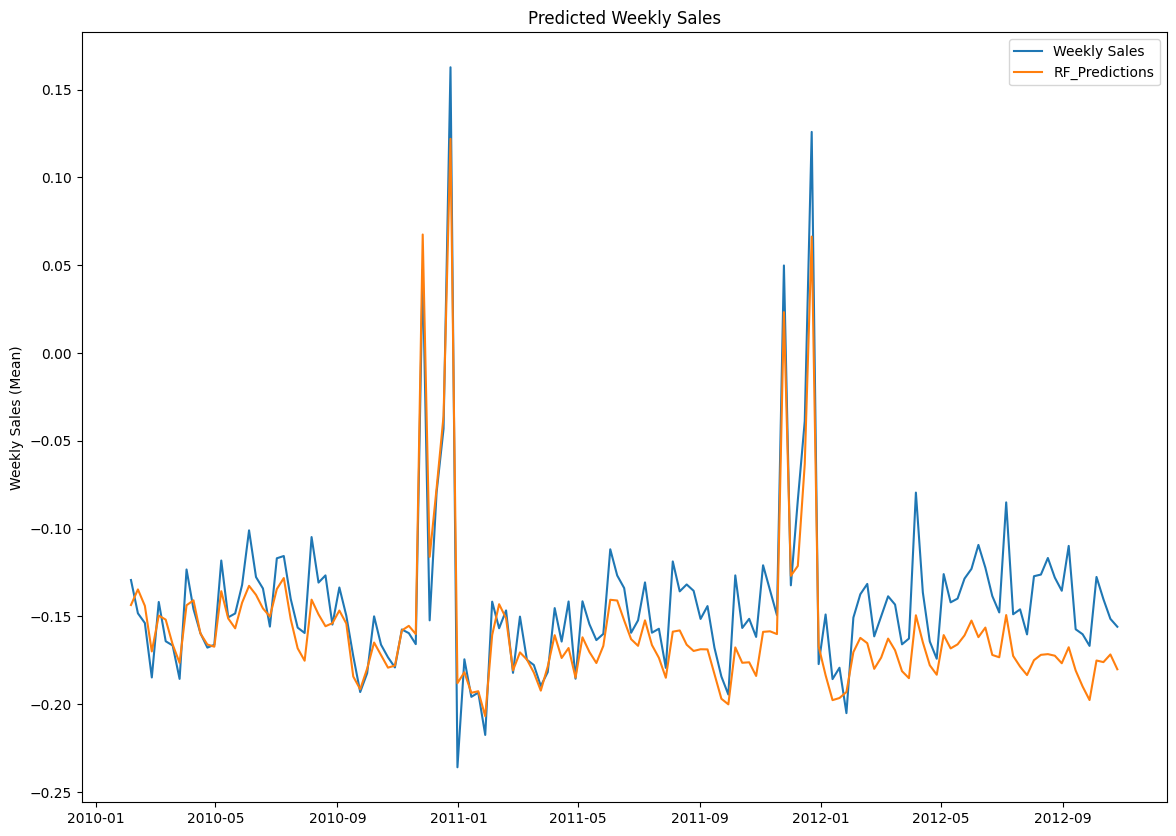

In [93]:
# Plotting the visualizations 

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'RF_Predictions': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['RF_Predictions'], label='RF_Predictions')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()

`XGBoost regressor`

In [114]:
# Initialize XGBoost Regressor
xgb = XGBRegressor(n_estimators=1000)
xgb.fit(X_train,y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [115]:
# Evaluating the model 

# Getting the predicted values from the regressor 
test['XGB_Predictions'] = xgb.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(test['Weekly_Sales'], test['XGB_Predictions'])
mae = mean_absolute_error(test['Weekly_Sales'], test['XGB_Predictions'])
r2 = r2_score(test['Weekly_Sales'], test['XGB_Predictions'])

# Printing the evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 0.2072
Mean Absolute Error: 0.2867
R-squared: 0.7049


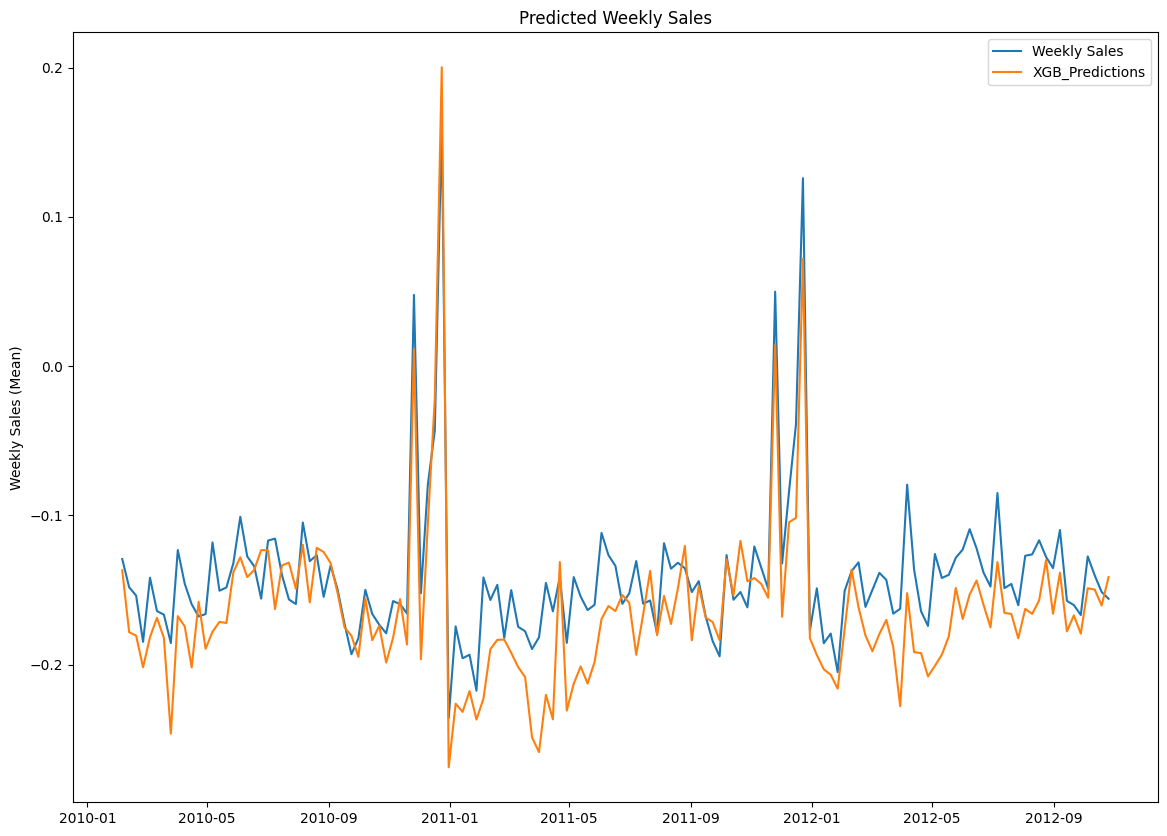

In [116]:
# Plotting the visualizations 

# Grouping the testset to prepare for visualizations
test.reset_index(inplace=True)
test_date = test.groupby('Date').agg({'Weekly_Sales': 'mean',
                                        'XGB_Predictions': 'mean'}).reset_index()

# Plotting both 'Weekly_Sales' and 'Predictions'
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(test_date['Date'], test_date['Weekly_Sales'], label='Weekly Sales')
ax.plot(test_date['Date'], test_date['XGB_Predictions'], label='XGB_Predictions')

# Adding labels and title
ax.set_ylabel("Weekly Sales (Mean)")
ax.set_title('Predicted Weekly Sales')
ax.legend()

# Displaying the plot
plt.show()